# Regression Tabular Model for Kaggle Playground Series Season 3 Episode 8 Using Python and TensorFlow Decision Forests
### David Lowe
### March 28, 2023

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Playground Series Season 3 Episode 6 Dataset is a regression modeling situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions to give the Kaggle community a variety of reasonably lightweight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The dataset for this competition was generated from a deep learning model trained on the Gemstone Price Prediction dataset. Feature distributions are close to but different from the original.

ANALYSIS: We selected Random Forest as the final model as it processed the training dataset with an RMSE score of 490. When we tested the final model using the test dataset, the model achieved an RMSE score of 582.

CONCLUSION: In this iteration, the Random Forest model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Playground Series Season 3, Episode 8

Dataset ML Model: Regression with numerical features

Dataset Reference: https://www.kaggle.com/competitions/playground-series-s3e8/

One source of potential performance benchmarks: https://www.kaggle.com/competitions/playground-series-s3e8/leaderboard

## Task 1 - Prepare Environment

In [1]:
# Install TensorFlow Decision Forests
!pip3 install tensorflow_decision_forests --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


### 1.a) Load libraries and modules

In [3]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [4]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
import zipfile
import urllib
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import metrics
from sklearn import datasets

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
# from tensorflow import keras
import tensorflow_decision_forests as tfdf

### 1.b) Set up the controlling parameters and functions

In [5]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'price'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 10
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'mean_squared_error'
DEFAULT_METRICS = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]

# Define the directory locations and file names
TRAIN_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e08/train.csv'
TEST_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e08/test.csv'
ORIGINAL_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e08/cubic_zirconia.csv'
SUBMISSION_TEMPLATE = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e08/sample_submission.csv'
SUBMISSION_FILE = 'submission_decisionForests_'

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow version: 2.12.0
Found TensorFlow Decision Forests v1.3.0


### 1.c) Load dataset

In [6]:
df_dataset_import = pd.read_csv(TRAIN_DATASET)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  carat        cut color clarity  depth  table     x     y     z  price
0   0   1.52    Premium     F     VS2   62.2   58.0  7.27  7.33  4.55  13619
1   1   2.03  Very Good     J     SI2   62.0   58.0  8.06  8.12  5.05  13387
2   2   0.70      Ideal     G     VS1   61.2   57.0  5.69  5.73  3.50   2772
3   3   0.32      Ideal     G     VS1   61.6   56.0  4.38  4.41  2.71    666
4   4   1.70    Premium     G     VS2   62.6   59.0  7.65  7.61  4.77  14453


In [7]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB


In [8]:
print(df_dataset_import.describe())

                  id          carat          depth          table  \
count  193573.000000  193573.000000  193573.000000  193573.000000   
mean    96786.000000       0.790688      61.820574      57.227675   
std     55879.856166       0.462688       1.081704       1.918844   
min         0.000000       0.200000      52.100000      49.000000   
25%     48393.000000       0.400000      61.300000      56.000000   
50%     96786.000000       0.700000      61.900000      57.000000   
75%    145179.000000       1.030000      62.400000      58.000000   
max    193572.000000       3.500000      71.600000      79.000000   

                   x              y              z          price  
count  193573.000000  193573.000000  193573.000000  193573.000000  
mean        5.715312       5.720094       3.534246    3969.155414  
std         1.109422       1.102333       0.688922    4034.374138  
min         0.000000       0.000000       0.000000     326.000000  
25%         4.700000       4.710000   

In [9]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [10]:
# Fetch the original dataset and use it to supplement the training
df_dataset_original = pd.read_csv(ORIGINAL_DATASET)
df_dataset_original.drop(columns=['Unnamed: 0'], inplace=True)
df_dataset_original['is_synthetic'] = 0

# Take a peek at the dataframe after import
print(df_dataset_original.head())

   carat        cut color clarity  depth  table     x     y     z  price  \
0   0.30      Ideal     E     SI1   62.1   58.0  4.27  4.29  2.66    499   
1   0.33    Premium     G      IF   60.8   58.0  4.42  4.46  2.70    984   
2   0.90  Very Good     E    VVS2   62.2   60.0  6.04  6.12  3.78   6289   
3   0.42      Ideal     F     VS1   61.6   56.0  4.82  4.80  2.96   1082   
4   0.31      Ideal     F    VVS1   60.4   59.0  4.35  4.43  2.65    779   

   is_synthetic  
0             0  
1             0  
2             0  
3             0  
4             0  


In [11]:
# Combine the original and synthetic datasets into one training dataset
df_dataset_import['is_synthetic'] = 1
df_dataset_import.drop(columns=['id'], inplace=True)
df_dataset_import = pd.concat([df_dataset_import, df_dataset_original],
                              ignore_index=True)

df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220540 entries, 0 to 220539
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   carat         220540 non-null  float64
 1   cut           220540 non-null  object 
 2   color         220540 non-null  object 
 3   clarity       220540 non-null  object 
 4   depth         219843 non-null  float64
 5   table         220540 non-null  float64
 6   x             220540 non-null  float64
 7   y             220540 non-null  float64
 8   z             220540 non-null  float64
 9   price         220540 non-null  int64  
 10  is_synthetic  220540 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 18.5+ MB


In [12]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())
print(df_dataset_import.tail())

   carat        cut color clarity  depth  table     x     y     z  target  \
0   1.52    Premium     F     VS2   62.2   58.0  7.27  7.33  4.55   13619   
1   2.03  Very Good     J     SI2   62.0   58.0  8.06  8.12  5.05   13387   
2   0.70      Ideal     G     VS1   61.2   57.0  5.69  5.73  3.50    2772   
3   0.32      Ideal     G     VS1   61.6   56.0  4.38  4.41  2.71     666   
4   1.70    Premium     G     VS2   62.6   59.0  7.65  7.61  4.77   14453   

   is_synthetic  
0             1  
1             1  
2             1  
3             1  
4             1  
        carat        cut color clarity  depth  table     x     y     z  \
220535   1.11    Premium     G     SI1   62.3   58.0  6.61  6.52  4.09   
220536   0.33      Ideal     H      IF   61.9   55.0  4.44  4.42  2.74   
220537   0.51    Premium     E     VS2   61.7   58.0  5.12  5.15  3.17   
220538   0.27  Very Good     F    VVS2   61.8   56.0  4.19  4.20  2.60   
220539   1.25    Premium     J     SI1   62.0   58.0  6.90 

In [13]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220540 entries, 0 to 220539
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   carat         220540 non-null  float64
 1   cut           220540 non-null  object 
 2   color         220540 non-null  object 
 3   clarity       220540 non-null  object 
 4   depth         219843 non-null  float64
 5   table         220540 non-null  float64
 6   x             220540 non-null  float64
 7   y             220540 non-null  float64
 8   z             220540 non-null  float64
 9   target        220540 non-null  int64  
 10  is_synthetic  220540 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 18.5+ MB


In [14]:
print(df_dataset_import.describe())

               carat          depth          table              x  \
count  220540.000000  219843.000000  220540.000000  220540.000000   
mean        0.791628      61.811561      57.255604       5.717090   
std         0.464561       1.126671       1.961255       1.111782   
min         0.200000      50.800000      49.000000       0.000000   
25%         0.400000      61.200000      56.000000       4.700000   
50%         0.700000      61.900000      57.000000       5.700000   
75%         1.030000      62.400000      58.000000       6.520000   
max         4.500000      73.600000      79.000000      10.230000   

                   y              z         target   is_synthetic  
count  220540.000000  220540.000000  220540.000000  220540.000000  
mean        5.721742       3.534712    3965.531450       0.877723  
std         1.110328       0.692876    4033.215125       0.327606  
min         0.000000       0.000000     326.000000       0.000000  
25%         4.710000       2.900000   

In [15]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

carat             0
cut               0
color             0
clarity           0
depth           697
table             0
x                 0
y                 0
z                 0
target            0
is_synthetic      0
dtype: int64
Total number of NaN in the dataframe:  697


### 1.e) Splitting Data into Sets

In [16]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (220540, 11) df_features_train.shape: (220540, 10) df_target_train.shape: (220540,)


### 1.f) Set up the parameters for data visualization

In [17]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

## Task 2 - Summarize and Visualize Data

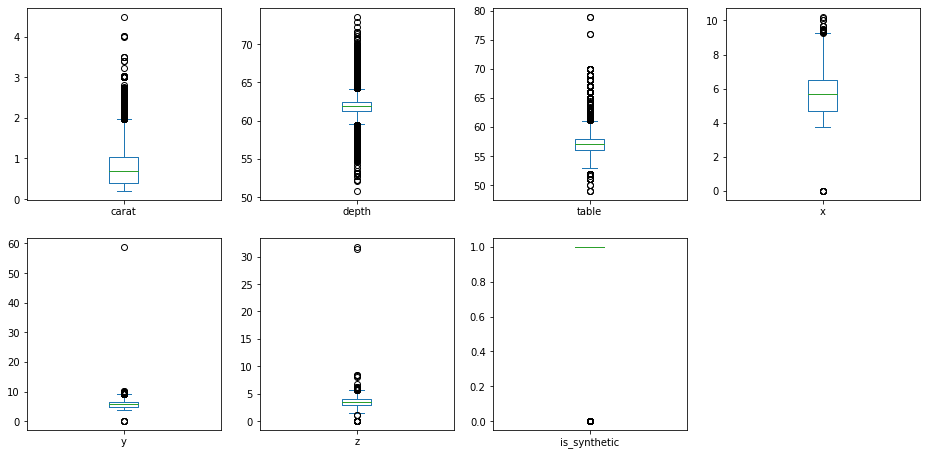

In [18]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

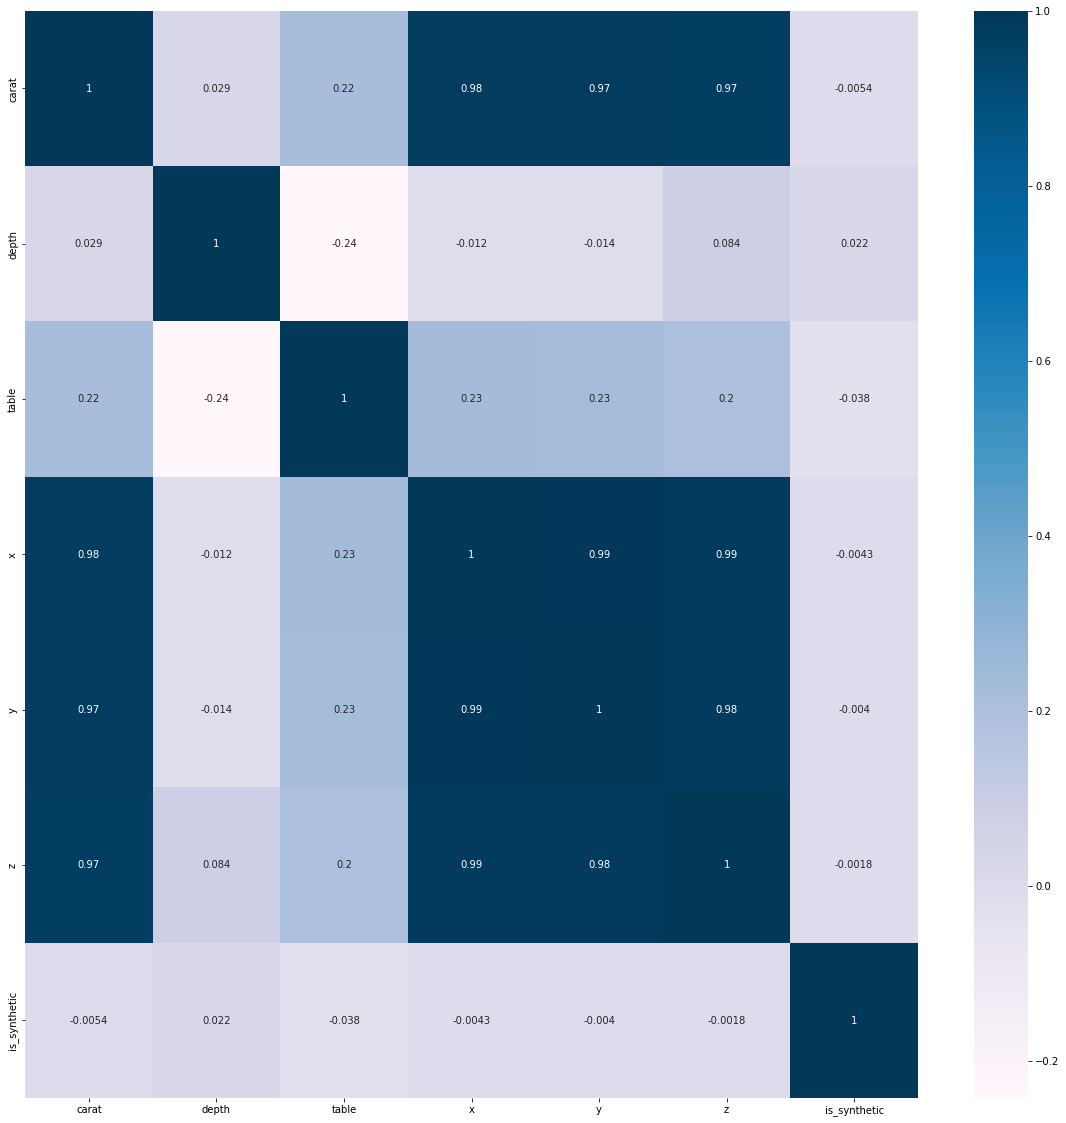

In [19]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

## Task 3 - Pre-process Data

### 3.a) Feature Scaling and Data Pre-Processing

In [20]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int','float']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="median")),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 7
Number of categorical columns: 3
Total number of columns in the feature dataframe: 10


In [21]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
], remainder='passthrough')

### 3.b) Finalize Datasets for Model-Building

In [22]:
# Finalize the training dataset for the modeling activities
array_features_train = preprocessor.fit_transform(df_features_train)
array_target_train = df_target_train.to_numpy()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array_features_train.shape: (220540, 27) array_target_train.shape: (220540,)


## Task 4 - Train and Evaluate Models

### 4.a) Train and Evaluate the Random Forest Model

In [23]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
RF_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
RF_model.compile(metrics=DEFAULT_METRICS)
RF_model.fit(x=array_features_train, y=array_target_train)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Use /tmp/tmpfq3x1bss as temporary training directory
Reading training dataset...
Training dataset read in 0:00:07.105113. Found 220540 examples.
Training model...
Model trained in 0:01:57.882123
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Total time for model fitting: 0:02:07.160438


In [24]:
RF_model.evaluate(x=array_features_train, y=array_target_train)

6892/6892 [==============================] - 36s 5ms/step - loss: 0.0000e+00 - rmse: 490.8203


[0.0, 490.82025146484375]

In [25]:
RF_model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (27):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.13
	data:0.14
	data:0.15
	data:0.16
	data:0.17
	data:0.18
	data:0.19
	data:0.2
	data:0.20
	data:0.21
	data:0.22
	data:0.23
	data:0.24
	data:0.25
	data:0.26
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "data:0.4"  0.260161 ################
    2.  "data:0.0"  0.221954 ############
    3.  "data:0.3"  0.164208 ########
    4. "data:0.22"  0.123064 ####
    5.  "data:0.5"  0.110823 ###
    6. "data:0.17"  0.090277 #
    7. "data:0.21"  0.090155 #
    8. "data:0.18"  0.089286 #
    9. "

### 4.c) Train and Evaluate the Decision Trees Model

In [26]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
CART_model = tfdf.keras.CartModel(task = tfdf.keras.Task.REGRESSION)
CART_model.compile(metrics=DEFAULT_METRICS)
CART_model.fit(x=array_features_train, y=array_target_train)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Use /tmp/tmpwkoyifxv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.917284. Found 220540 examples.
Training model...
Model trained in 0:00:01.596658
Compiling model...
Model compiled.
Total time for model fitting: 0:00:04.186823


In [27]:
CART_model.evaluate(x=array_features_train, y=array_target_train)

6892/6892 [==============================] - 11s 2ms/step - loss: 0.0000e+00 - rmse: 538.4943


[0.0, 538.4942626953125]

In [28]:
CART_model.summary()

Model: "cart_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (27):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.13
	data:0.14
	data:0.15
	data:0.16
	data:0.17
	data:0.18
	data:0.19
	data:0.2
	data:0.20
	data:0.21
	data:0.22
	data:0.23
	data:0.24
	data:0.25
	data:0.26
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "data:0.4"  1.000000 ################
    2.  "data:0.0"  0.210361 ##
    3.  "data:0.3"  0.197974 ##
    4. "data:0.25"  0.118373 
    5. "data:0.16"  0.111012 
    6. "data:0.22"  0.100584 
    7. "data:0.17"  0.094341 
    8. "data:0.18"  0.090161 
    9. "data:0.26"  0.086719 
   10. "data:

### 4.d) Train and Evaluate the Gradient Boosted Trees Model

In [29]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
GBT_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)
GBT_model.compile(metrics=DEFAULT_METRICS)
GBT_model.fit(x=array_features_train, y=array_target_train)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Use /tmp/tmp8mnuijlo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.195204. Found 220540 examples.
Training model...
Model trained in 0:01:29.665530
Compiling model...
Model compiled.
Total time for model fitting: 0:02:22.389648


In [30]:
GBT_model.evaluate(x=array_features_train, y=array_target_train)

6892/6892 [==============================] - 12s 2ms/step - loss: 0.0000e+00 - rmse: 541.0170


[0.0, 541.0170288085938]

In [31]:
GBT_model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (27):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.13
	data:0.14
	data:0.15
	data:0.16
	data:0.17
	data:0.18
	data:0.19
	data:0.2
	data:0.20
	data:0.21
	data:0.22
	data:0.23
	data:0.24
	data:0.25
	data:0.26
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "data:0.4"  0.255592 ################
    2.  "data:0.0"  0.226486 ##########
    3.  "data:0.3"  0.225810 ##########
    4.  "data:0.5"  0.219134 #########
    5.  "data:0.1"  0.199039 #####
    6.  "data:0.2"  0.192780 ####
    7. "data:0.12"  0.186530 ##
    8. "da

### 4.e) Algorithm Tuning

In [32]:
# Not applicable for this iteration of modeling

## Task 5 - Finalize Model and Present Analysis

### 5.a) Train the Final Model

In [33]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
final_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
# final_model = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
# final_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
final_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     final_model.fit(x=tfds_train)

# Train the model.
final_model.fit(x=array_features_train, y=array_target_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpj7hf4c0u as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.947076. Found 220540 examples.
Training model...
Model trained in 0:01:52.494733
Compiling model...
Model compiled.
Model training time: 0:02:22.409980 



In [34]:
final_model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (27):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.13
	data:0.14
	data:0.15
	data:0.16
	data:0.17
	data:0.18
	data:0.19
	data:0.2
	data:0.20
	data:0.21
	data:0.22
	data:0.23
	data:0.24
	data:0.25
	data:0.26
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "data:0.4"  0.260161 ################
    2.  "data:0.0"  0.221954 ############
    3.  "data:0.3"  0.164208 ########
    4. "data:0.22"  0.123064 ####
    5.  "data:0.5"  0.110823 ###
    6. "data:0.17"  0.090277 #
    7. "data:0.21"  0.090155 #
    8. "data:0.18"  0.089286 #
    9.

### 5.b) Load Test Dataset and Make Predictions

In [35]:
df_features_test = pd.read_csv(TEST_DATASET)
df_features_test['is_synthetic'] = 1

# Take a peek at the dataframe after import
print(df_features_test.head())

       id  carat        cut color clarity  depth  table     x     y     z  \
0  193573   0.35      Ideal     D     VS2   62.3   56.0  4.51  4.54  2.82   
1  193574   0.77  Very Good     F     SI2   62.8   56.0  5.83  5.87  3.68   
2  193575   0.71      Ideal     I     VS2   61.9   53.0  5.77  5.74  3.55   
3  193576   0.33      Ideal     G    VVS2   61.6   55.0  4.44  4.42  2.73   
4  193577   1.20  Very Good     I     VS2   62.7   56.0  6.75  6.79  4.24   

   is_synthetic  
0             1  
1             1  
2             1  
3             1  
4             1  


In [36]:
id_column_name = df_features_test.columns[0]
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission[id_column_name] = df_features_test[id_column_name]
print(df_kaggle_submission.head())

       id
0  193573
1  193574
2  193575
3  193576
4  193577


In [37]:
# Take a peek at the dataframe after cleaning
print(df_features_test.head())

       id  carat        cut color clarity  depth  table     x     y     z  \
0  193573   0.35      Ideal     D     VS2   62.3   56.0  4.51  4.54  2.82   
1  193574   0.77  Very Good     F     SI2   62.8   56.0  5.83  5.87  3.68   
2  193575   0.71      Ideal     I     VS2   61.9   53.0  5.77  5.74  3.55   
3  193576   0.33      Ideal     G    VVS2   61.6   55.0  4.44  4.42  2.73   
4  193577   1.20  Very Good     I     VS2   62.7   56.0  6.75  6.79  4.24   

   is_synthetic  
0             1  
1             1  
2             1  
3             1  
4             1  


In [38]:
print(df_features_test.describe())

                  id          carat          depth          table  \
count  129050.000000  129050.000000  129050.000000  129050.000000   
mean   258097.500000       0.789256      61.820522      57.239608   
std     37253.670457       0.462502       1.080249       1.918908   
min    193573.000000       0.200000      53.200000      51.000000   
25%    225835.250000       0.400000      61.300000      56.000000   
50%    258097.500000       0.700000      61.900000      57.000000   
75%    290359.750000       1.030000      62.400000      58.000000   
max    322622.000000       4.500000      70.600000      70.000000   

                   x              y              z  is_synthetic  
count  129050.000000  129050.000000  129050.000000      129050.0  
mean        5.711767       5.716336       3.531802           1.0  
std         1.109666       1.102485       0.690749           0.0  
min         0.000000       0.000000       0.000000           1.0  
25%         4.700000       4.710000       2

In [39]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (129050, 11) to array_features_test.shape: (129050, 27)


In [40]:
# Make batched predictions
test_predictions = final_model.predict(x=array_features_test)
print(test_predictions)

4033/4033 [==============================] - 21s 5ms/step
[[ 857.1066]
 [2443.9055]
 [2317.2363]
 ...
 [7555.3037]
 [5669.952 ]
 [4220.5317]]


In [41]:
df_sample_submission = pd.read_csv(SUBMISSION_TEMPLATE)
df_sample_submission.drop(columns=[id_column_name], inplace=True)
submission_header = list(df_sample_submission.columns)[0]
print(submission_header)

price


In [42]:
df_kaggle_submission[submission_header] = test_predictions
print(df_kaggle_submission.head())

       id        price
0  193573   857.106628
1  193574  2443.905518
2  193575  2317.236328
3  193576   823.608276
4  193577  5825.952637


In [43]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = SUBMISSION_FILE + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_decisionForests_20230326-1334.csv


In [44]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:08:29.919146
